# ðŸ§± GANs on Bricks Data - Generate

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Load the Model](#model)
3. [Reconstruct using the autoencoder](#reconstruct)
4. [Embed using the encoder](#encode)
5. [Generate using the decoder](#decode)
6. [Explore the latent space](#explore)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%%html
<style>table {display: inline-block}</style>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import norm

# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, Layer, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback
from tensorflow.keras.losses import binary_crossentropy, BinaryCrossentropy
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import array_to_img

from utils.image import display
from utils.datasets import sample_batches, sample_batch
from utils.losses import root_mean_squared_error

ImportError: cannot import name 'compare_images' from 'utils.image' (/app/utils/image.py)

## 0. Parameters <a name="parameters"></a>

In [5]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 300

## 1. Prepare the data <a name="prepare"></a>

In [10]:
# Load all the data
train_data = image_dataset_from_directory(
    "/app/data/lego-brick-images/dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 40000 files belonging to 1 classes.


In [11]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img

train = train_data.map(lambda x: preprocess(x))

## 2. Load the models <a name="model"></a>

In [73]:
## Load the model trained in 01_train.ipynb
generator = load_model("./models/generator", compile=False)
discriminator = load_model("./models/discriminator", compile=False)

## 3. Generate new images <a name="decode"></a>

In [74]:
#Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10,3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [75]:
# Decode the sampled points
reconstructions = generator.predict(z_sample)

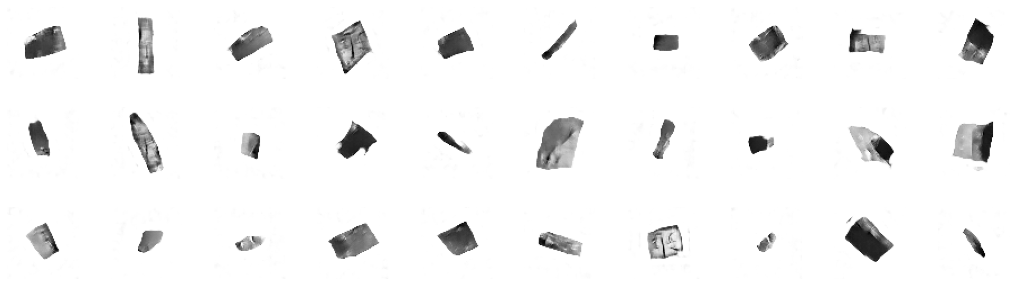

In [76]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

#Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap = 'Greys')

In [16]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [23]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

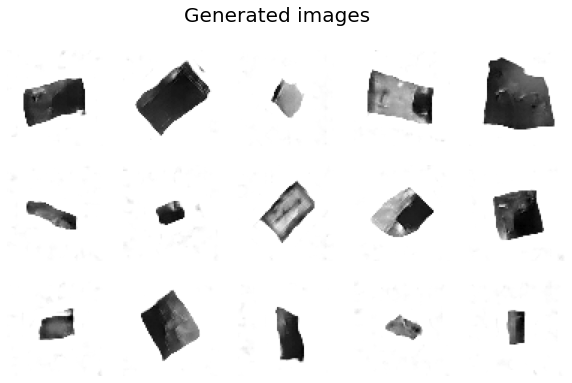

In [95]:
r, c = 3,5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle('Generated images', fontsize= 20)

noise = np.random.normal(size = (r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

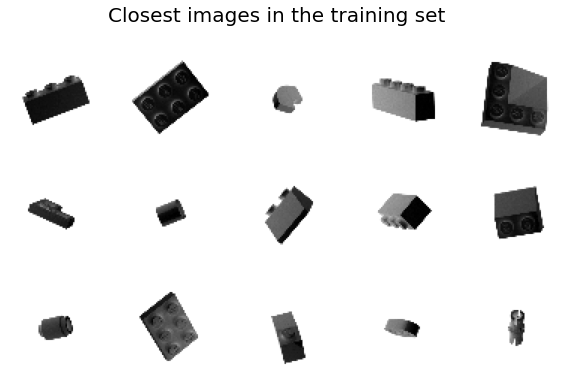

In [96]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle('Closest images in the training set', fontsize= 20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()